# Tourenplanung für Ride-Sharing-Dienstleister

Ein spezielles Tourenplanungsproblem, dass sich mit der Planung von Touren für Ride-Sharing-Dienstleister befasst ist das Dial-a-ride Problem (DARP). Dieses unterscheidet sich von anderen Tourenplanungsproblem zunächst darin, dass sowohl Pickups als auch Drop-offs geplant werden. Außerdem entsteht sich durch das spezielle Förderungsgut "Kunde" eine paarweise Verbindung zwischen Pickups und Dropoffs. Im Gegensatz zu einem homogenen Gut kann ein Drop-off nicht von einem beliebigen Pick-up bedient werden [1]. Zusätzlich ergeben sich durch die Beförderung von Kunden, weitere Nebenbedingungen, wie die im Fahrzeug verbrachte Zeit [2].

Eine standard Definition des Problems kommt von Cordeau und Laporte [2]:

<center>"In the dial-a-ride problem (DARP), *n* users specify transportation requests between given origins and destinations. Users may provide a time window on their desired departure or arrival time, or on both. Transportation is supplied by a fleet of *m* vehicles based at a common depot. The aim is to design a set of least cost vehicle routes capable of accommodating all requests, under a set of constraints." [2, p.1]</center>

Im Weiteren beschäftigen wir uns mit einer vereinfachten Version des dynamischen DARPs, wie es von Haferkamp und Ehmke [3] vorgestellt wird.

## Teil 1: Das Problem

Zunächst importieren wir die benötigten Libraries.

In [22]:
import sys
from copy import deepcopy
import ipywidgets as widgets
import matplotlib.pyplot as plt

$L$:  locations ($l \in L$)

- *loc:* Koordinaten der Location
- *request:* Zugehöriges Request zur Location

$o_r$: origins ($o_r \in L_o \subset L$)

- erbt von Location

$d_r$: destinations ($d_r \in L_d \subset L$)

- erbt von Location

Es gibt 3 Kunden, die an den Koordinaten (1,8), (6,5) und (3,2) zu- und an den Koordinaten (5,9), (3,4) und (8,5) aussteigen. Führen Sie den folgenden Code aus um einen Graf der Anfangskoordinaten (blau) und Endkoordinaten (rot) zu generieren.

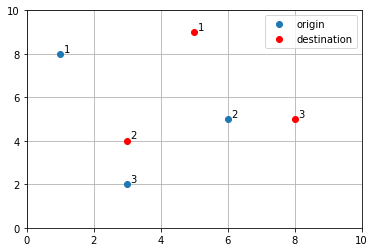

In [23]:
#Kürzer Formulieren oder Einklappen?
plt.plot([1,6,3],[8,5,2],'o', label ="origin")
plt.plot([5,3,8],[9,4,5],'ro', label = "destination")
plt.text((1+0.1),(8+0.1), 1)
plt.text((5+0.1),(9+0.1), 1)
plt.text((6+0.1),(5+0.1), 2)
plt.text((3+0.1),(4+0.1), 2)
plt.text((3+0.1),(2+0.1), 3)
plt.text((8+0.1),(5+0.1), 3)
plt.axis([0,10,0,10])
plt.grid()
plt.legend()
plt.show()
# Slider für Zeitverlauf

In [27]:
#Suchen Sie sich den Pickup und den Dropoff Punkt des 5ten Kunden nach mit den folgenden Slidern selbst aus:
xo = widgets.IntSlider( value = 6, max = 10, description = 'X-Koordinate Origin')
# IntText
display(xo)
problem.addRequest((xo, xd), (yo,yd), rt)

IntSlider(value=6, description='X-Koordinate Origin', max=10)

In [1]:
# ? Erst später, kurz erklären, dass als distanz und kosten verwendet
def euclidean(loc1, loc2):
    return ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5

# Einführungstext

In [2]:
class Location:

    def __init__(self, loc, req):
        self.loc = loc
        self.request = req


class Origin(Location):
    is_origin = True
    is_destination = False

    def __init__(self, loc, req):
        super().__init__(loc, req)


class Destination(Location):
    is_origin = False
    is_destination = True

    def __init__(self, loc, req):
        super().__init__(loc, req)


$R$:  requests ($r \in R$)

- receiving time $t_r$
- origin $o_r \in L$
- destination $d_r \in L$
- time window $[b_r, e_r]$
    - $b_r = t_r$
    - $e_r = t_r + c_{o_r,d_r} + \alpha$

In [3]:
class Request:
    _count = 0

    def __init__(self, orig_loc, dest_loc, req_t, alpha=15):
        self.id = Request._count
        Request._count += 1
        self.req_t = req_t
        self.alpha = alpha
        self.end_t = req_t + euclidean(orig_loc, dest_loc) + alpha
        self.origin = Origin(orig_loc, self)
        self.destination = Destination(dest_loc, self)

In [ ]:
kunde1 = Request((1,8), (5,9), 7.1, 10)
kunde2 = Request((6,5), (3,4), 0, 10)
kunde3 = Request((3,2), (8,5), 0, 10)

$V$:  vehicles ($v \in V$)

In [4]:
class Tour:

    def __init__(self, depot_loc=(0, 0), M=sys.maxsize):
        depot = Request(depot_loc, depot_loc, 0, M)
        self.tour = [depot.origin, depot.destination]
        self.early = [0, 0]
        self.late = [M, M]
        self.length = 2
        self.total_cost = 0
        self.M = M

    # Beim Updaten bestimmen
    def get_total_cost(self):
        pass

    # Überprüfe, ob Pick-Up / Drop-Off (place) des Kunden an Position i in der Tour zulässig ist
    def feasible(self, place, i):
        # Für Destination muss gelten: Pick-Up vor Drop-Off, Drop-Off in der gleichten Tour wie Pick-Up
        if place.is_destination and place.request.origin not in self.tour[:i]:
            return False
        # Origin nicht nach Destination einfügbar
        if place.is_origin and place.request.destination in self.tour[:i]:
            return False
        # überprüfen der Zeitfenster: Early < Late
        e, l = self.insertion_time_window(place, i)
        return e <= l

    # Einfügekosten, die entstehen, falls Location in Tour an Position i eingefügt wird
    def insertion_cost(self, place, i):
        return (euclidean(self.tour[i-1].loc, place.loc) + euclidean(place.loc, self.tour[i].loc)
                - euclidean(self.tour[i-1].loc, self.tour[i].loc))

    # berechne Zeitfenster
    def insertion_time_window(self, place, i):
        e = max(place.request.req_t, self.early[i-1] + euclidean(self.tour[i-1].loc, place.loc))
        l = min(place.request.end_t, self.late[i] - euclidean(place.loc, self.tour[i].loc))
        return e, l

    def insert(self, place, i):
        self.total_cost += self.insertion_cost(place, i)
        self.tour.insert(i, place)
        self.length += 1
        self.update(i)

    def update(self, i):
        # Berechnung und Einfügen des Zeitfensters des neuen Ortes
        e, l = self.insertion_time_window(self.tour[i], i)
        self.early.insert(i, e)
        self.late.insert(i, l)
        # Update der Zeitfenster (late) der vorigen Orte
        for k in range(i-1, -1, -1):
            self.late[k] = min(self.late[k], self.late[k+1] - euclidean(self.tour[k].loc, self.tour[k+1].loc))
        # Update der Zeitfenster (early) der nachfolgenden Orte
        for k in range(i+1, self.length):
            self.early[k] = max(self.early[k], self.early[k-1] + euclidean(self.tour[k-1].loc, self.tour[k].loc))
    
    def printable(self):
        abfolge = []
        for i in range(self.length):
            type = "Origin" if self.tour[i].is_origin else "Destination"
            abfolge.append((self.tour[i].request.id, self.tour[i].loc, self.early[i], type))
        return abfolge

In [6]:
tour1 = Tour((1, 1))
tour2 = Tour((6, 6))

### Insertion-Heuristik

In [5]:
def parallel_insertion(tours, requests, M=sys.maxsize):
    reject = []
    # Kunden = copy.deepcopy(fiktivekunden)
    
    while requests: # Braucht man hier nicht =/= []?
        pOpt = M 
        for j in range(len(requests)):
            for k in range(len(tours)):
                # spos: Position in Tour k, an der der Pickup des Kunden eingefügt wird
                for spos in range(1, tours[k].length):
                    if tours[k].feasible(requests[j].origin, spos):
                        skosten = tours[k].insertion_cost(requests[j].origin, spos)
                        
                        # speichert die aktuell gültige Tour in einer temporären Variablen
                        tour_temp = deepcopy(tours[k])
                        
                        # füge den Pickup des Kunden vorübergehend in den Tourenplan ein und Update der Zeitfenster
                        tour_temp.insert(requests[j].origin, spos)
                        
                        # Prüfe für alle Positionen im Tourenplan nach dem eingefügten Pickup ob es einen möglichen Drop-off gibt 
                        for epos in range(spos+1, tour_temp.length): 
                            if tour_temp.feasible(requests[j].destination, epos):  
                                ekosten = tour_temp.insertion_cost(requests[j].destination, epos)
                                if skosten + ekosten < pOpt:
                                    reqOpt = requests[j] 
                                    tourOpt = tours[k] 
                                    sposOpt = spos
                                    eposOpt = epos
                                    pOpt = skosten + ekosten   
      
        if pOpt < M:   
            # Setze den Pickup und Drop-Off des Kunden ein und aktualisiere Zeitfenster
            tourOpt.insert(reqOpt.origin, sposOpt)
            tourOpt.insert(reqOpt.destination, eposOpt)
            
            #Entferne den eigesetzten Kunden aus der Liste der noch ausstehenden Kunden
            requests.remove(reqOpt)         
        else:
            # Wenn kein Kunde den Feasibility mehr besteht, speichere die abgewiesenen Kunden und leere die Liste
            reject = deepcopy(requests)
            requests = []
   
    return tours, reject

In [7]:
tours, reject = parallel_insertion([tour1, tour2], [kunde1, kunde2, kunde3])
for tour in tours:
    # ID, Location, (früheste) Besuchszeit, Origin/Destination
    print(tour.printable())

[(0, (1, 1), 0, 'Origin'), (2, (1, 8), 7.1, 'Origin'), (2, (5, 9), 11.22310562561766, 'Destination'), (0, (1, 1), 20.16737753561682, 'Destination')]
[(1, (6, 6), 0, 'Origin'), (3, (6, 5), 1.0, 'Origin'), (3, (3, 4), 4.16227766016838, 'Destination'), (4, (3, 2), 6.16227766016838, 'Origin'), (4, (8, 5), 11.99322955501368, 'Destination'), (1, (6, 6), 14.22929753251347, 'Destination')]


To-do:
- printable-Funktion für Tour --> Erledigt
- Zeitepochen --> Heute

$K$:  Entscheidungsepochen ($k \in K$)

In [9]:
class Decision_Epoch:
    pass

In [14]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [18]:
w.value*2

174

[1] Parragh, S. N., Doerner, K. F., & Hartl, R. F. (2008). A survey on pickup and delivery problems. Part II:
Transportation between pickup and delivery locations. Journal für Betriebswirtschaft, 58(2), 81–117.

[2] Cordeau, J.-F., & Laporte, G. (2003). A tabu search heuristic for the static multi-vehicle dial-a-ride problem.
Transportation Research Part B: Methodological, 37(6), 579–594.

[3 ]Haferkamp J, Ehmke J (2020): Evaluation of Anticipatory Decision-Making in
Ride-Sharing Services. Working Paper, Universität Magdeburg.